In [269]:
from pathlib import Path
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [270]:
plt.style.use("seaborn")
plt.rcParams["figure.figsize"] = (5, 3.5)
plt.rcParams["figure.dpi"] = 100

The manual for the induction probe (Auslog, originally W&R Instruments HI 327F) has this radial response curve defined:

![](hi_327f_manual_radial_response.png)

I then digitised this curve using [WebPlotDigitizer](https://automeris.io/WebPlotDigitizer/).

In [271]:
path = Path(r"r:\dfw_cbd\geophyslogs\equipment\probes\ind3s\response")
filename = str(path / "hi327f_radial_response.json")
with open(filename, "r") as f:
    data = json.load(f)

points = [x["value"] for x in data["datasetColl"][0]["data"]]
df = pd.DataFrame(points, columns=["geom_factor", "mag_field_response"])
df.to_csv("radial_response.csv")
df.head()

,geom_factor,mag_field_response
0,-0.000504,0.000307
1,0.028853,-0.006526
2,0.059580,-0.009138
3,0.090307,-0.011750
4,0.113976,-0.001770


Inter-coil spacing for this tool is 0.4 m. This allows conversion of the geometric factor into a radial distance.

Text(0,0.5,'Mag field response')

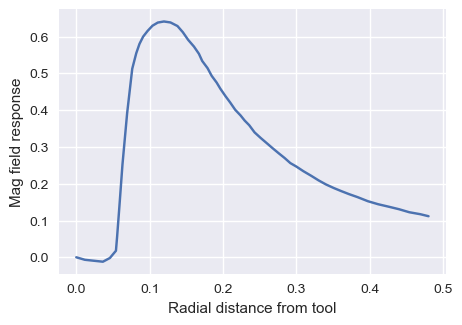

In [272]:
df = pd.read_csv("radial_response.csv")
df["radial_distance"] = df.geom_factor * 0.4
plt.plot(df.radial_distance, df.mag_field_response)
plt.xlabel("Radial distance from tool")
plt.ylabel("Mag field response")

(0, 0.2)

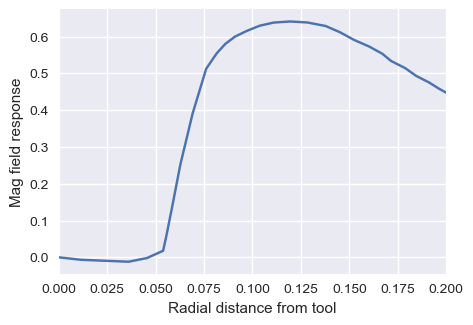

In [274]:
df = pd.read_csv("radial_response.csv")
df["radial_distance"] = df.geom_factor * 0.4
plt.plot(df.radial_distance, df.mag_field_response)
plt.xlabel("Radial distance from tool")
plt.ylabel("Mag field response")
plt.xlim(0, 0.2)

In [275]:
xarr = np.linspace(0, df.radial_distance.max())
df2 = pd.concat([df, pd.DataFrame({"radial_distance": xarr})])
df2 = df2.set_index("radial_distance").interpolate(method="slinear")

Need to extrapolate the solution to greater distances.

In [292]:
from scipy.optimize import curve_fit
import numpy as np


def model_func(x, a, b, c):
    return a * x ** (1 / b) + c


start_fit = 0.20
model_fit_df = df[df.radial_distance > start_fit]
popt, pvar = curve_fit(
    model_func,
    model_fit_df.radial_distance.values,
    model_fit_df.mag_field_response.values,
)

distances = np.linspace(start_fit, 2.0)
responses = model_func(distances, *popt)
responses[responses <= 0] = 0

Text(0,0.5,'Mag field response')

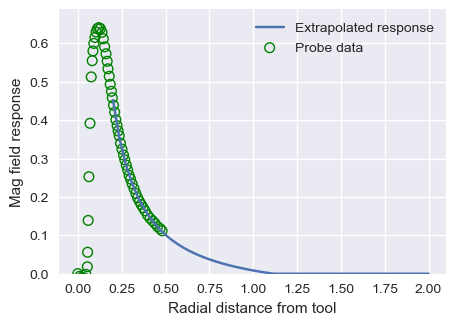

In [293]:
plt.scatter(
    df.radial_distance,
    df.mag_field_response,
    marker="o",
    facecolor="none",
    edgecolor="green",
    linewidth=1,
    label="Probe data",
)
plt.plot(distances, responses, label="Extrapolated response")
plt.ylim(0, None)
plt.legend(loc="best")
plt.xlabel("Radial distance from tool")
plt.ylabel("Mag field response")

OK. Merge the data and extrapolation and re-interpolate to 1 cm intervals.

In [294]:
df4 = pd.concat(
    [
        df[["radial_distance", "mag_field_response"]],
        pd.DataFrame({"radial_distance": distances, "mag_field_response": responses}),
    ]
).sort_values("radial_distance")
x = df4["radial_distance"].values
y = df4["mag_field_response"].values
xnew = np.linspace(0, 2, 2000)
ynew = interp1d(x, y)(xnew)
dfi = pd.DataFrame({"radial_distance": xnew, "mag_field_response": ynew})
dfi.head()
dfi.to_csv("radial_response_ind3s.csv", index=False)

(0, 1)

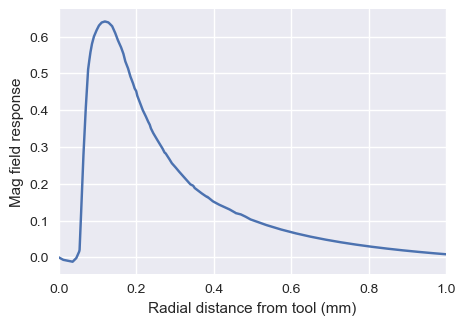

In [295]:
plt.plot(dfi.radial_distance, dfi.mag_field_response)
plt.xlabel("Radial distance from tool (mm)")
plt.ylabel("Mag field response")
plt.xlim(0, 1)

In [296]:
def proportion(radius):
    """Calculate fraction of response due to material <= radius."""
    df = dfi[dfi.mag_field_response >= 0]
    df0 = df[df.radial_distance <= (radius)]
    value0 = np.trapz(df0.mag_field_response.values, df0.radial_distance.values)
    total = np.trapz(df.mag_field_response.values, df.radial_distance.values)
    return value0 / total

Now we will make boreholes ranging from 0 to 400 mm in diameter, and calculate the proportion of the response which is due to material within the borehole.

In [297]:
diameters = np.arange(0, 400, 10) / 1000
props = np.asarray([proportion(d / 2.) for d in diameters])

Text(0,0.5,'% of response from borehole')

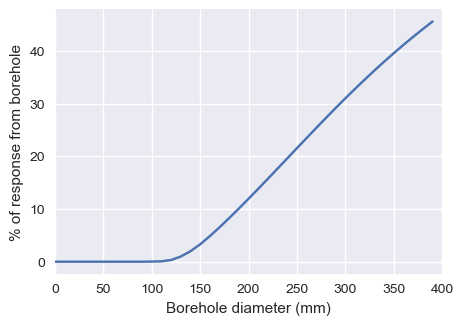

In [299]:
plt.plot(diameters * 1000, props * 100)
# plt.xlabel("Radial distance from tool (mm)")
# plt.ylabel("Mag field response")
plt.xlim(0, 400)
plt.xlabel("Borehole diameter (mm)")
plt.ylabel("% of response from borehole")